In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
#paramaters
pars = {}
pars['a00'] = - 21*10**-6
pars['a01'] = 1
pars['a10'] = - 1.348*10**-3
pars['a11'] = -1
pars['gamma0'] = 8.72*10**-6
pars['gamma1'] = 54.8*10**-3

pars['kbT'] = 4.1*10**-21
pars['noise0'] = np.sqrt(2*pars['gamma0']*pars['kbT'])
pars['noise1'] = np.sqrt(4.916*10**-12)

pars['delta_t'] = 0.00001


In [3]:
def analytical_soln_acf_generic(omega_list, pars):
    autocorr_list = []
    for omega in omega_list:
        numerator = ( pars['a11']**2 * pars['noise0']**2 ) \
        + ( pars['a01']**2 * pars['noise1']**2 ) \
        + ( (omega**2) * (pars['gamma1']**2) * (pars['noise0']**2) )

        denominator = ( -2*pars['a11']*pars['a00']*pars['a10']*pars['a01'] ) \
        + ( (omega**2) * (pars['gamma0']**2) * (pars['a11']**2) ) \
        + ( ( (pars['a10']*pars['a01']) + (pars['gamma0']*pars['gamma1']* (omega**2) ) )**2) \
        + ( (pars['a00']**2) * ( (pars['a11']**2) + (omega**2) * (pars['gamma1']**2) ) )

        autocorr = numerator/denominator
        autocorr_list.append(autocorr)
    return autocorr_list

In [4]:
def euler_one_traj(n_time, pars):   
    #initial condition
    x1 = 0
    x2 = 0
    x1_traj = []
    x2_traj = []
    
    #performing 1 traj with n_time number of data points
    for i in range(n_time):
        #generate delta_B
        s1 = np.random.normal(0, np.sqrt(pars['delta_t']) )
        s2 = np.random.normal(0, np.sqrt(pars['delta_t']) )
        #solve for x1, x2
        x1_new = x1 - (pars['a00']/pars['gamma0'])*x1*pars['delta_t'] - \
        (pars['a01']/pars['gamma0'])*x2*pars['delta_t'] + \
        np.sqrt((pars['noise0']**2)/(pars['gamma0']**2))*s1
                 
        x2_new = x2 - (pars['a11']/pars['gamma1'])*x2*pars['delta_t'] - \
        (pars['a10']/pars['gamma1'])*x1*pars['delta_t'] + \
        np.sqrt((pars['noise1']**2)/(pars['gamma1']**2))*s2
                
        x1 = x1_new
        x2 = x2_new
        
        x1_traj.append(x1)
        x2_traj.append(x2)
    return x1_traj, x2_traj

In [5]:
def euler_n_traj(max_time, pars):
    min_time = 0
    n_time = int((max_time - min_time)/pars['delta_t'] + 1) #n_time = num of evenly spaced samples (ex. 1001 points)
    time = np.linspace(min_time, max_time, n_time) #time(ex. 0 (min time), 0.01, 0.02, ..., 10 (max time)) with n_time no. of data points
    
    x_traj_list = []
    y_traj_list = []
    for i in tqdm(range(pars['n_realizations'])):
        x_traj, y_traj = euler_one_traj(n_time, pars)
        x_traj_list.append(x_traj)
        y_traj_list.append(y_traj)
        
    return x_traj_list, y_traj_list, time

In [6]:
#plot trajectories with t = 10s
pars['n_realizations'] = 10
length_plot = 0.005
x_traj_list, y_traj_list, time = euler_n_traj(length_plot, pars)

100%|██████████| 10/10 [00:00<00:00, 145.33it/s]


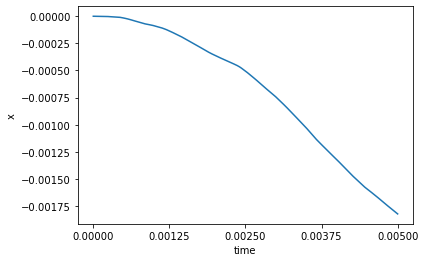

In [7]:
#Plot a sample trajectory
plt.plot(time, x_traj_list[3])
plt.xlabel('time')
plt.ylabel('x')
plt.xticks(np.linspace(0, length_plot, 5))
plt.show()

Calculate autocorrelation

In [8]:
def autocorr(x):
    tau = np.arange(1,len(x_traj_list[0]))
    
    corr_list = []
    for t in tau:
        xtau = np.roll(x, -t)
        
        product_list = []
        for x_value, xtau_value in zip(x, xtau):
            product = x_value*xtau_value
            product_list.append(product)
            
            
        corr = np.array(product_list[:-t]).mean()
        corr_list.append(corr)
    return corr_list

In [9]:
def ave_autocorr_traj(trajectory):
    autocorr_list = []
    for traj in trajectory:
        autocorr_traj = autocorr(np.array(traj))
        autocorr_list.append(autocorr_traj)
        
    matrix = np.array((autocorr_list))
    mean_per_column = matrix.mean(axis=0)
    
    return mean_per_column

In [10]:
%%time
xtraj = ave_autocorr_traj(x_traj_list)

Wall time: 969 ms


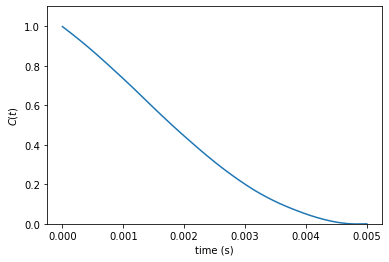

In [11]:
normalization = np.mean((np.array(x_traj_list))*(np.array(x_traj_list)))

plt.plot(np.linspace(0, length_plot, len(xtraj)), xtraj/normalization)
plt.ylim(0,1.1)
plt.xlabel('time (s)')
plt.ylabel('$C(t)$')
plt.show()

Transform $C(t)$ to $C(\omega)$

In [12]:
c_omega = np.fft.fft(xtraj/normalization)
tt = np.arange(0,len(c_omega))
freq = np.fft.fftfreq(tt.shape[-1], d=1)
print('c_omega', c_omega.real)
print('freq', freq)

c_omega [190.2779913   20.27295304   4.13044582   2.07796511   1.58889991
   1.18634938   0.8944242    0.83220997   0.74880062   0.70886601
   0.65778528   0.62287264   0.61030828   0.58997327   0.57433858
   0.56888889   0.55549921   0.55086381   0.54425889   0.54091063
   0.53390815   0.53268684   0.53132904   0.52980899   0.52705251
   0.5247012    0.52257409   0.52140279   0.52019554   0.51838995
   0.51626706   0.5147593    0.51491542   0.51374485   0.51325891
   0.51306406   0.51263489   0.51174      0.51068872   0.50992984
   0.50931805   0.50819679   0.50805663   0.50741972   0.50705246
   0.50664952   0.50639353   0.50612019   0.50604323   0.5057227
   0.50538919   0.5050711    0.50496622   0.50480424   0.50479601
   0.50455019   0.50439902   0.50410307   0.50385335   0.50358822
   0.50333032   0.50323879   0.50316672   0.50296396   0.50278394
   0.50264314   0.50262415   0.50247741   0.50236388   0.50222576
   0.5021194    0.50206455   0.50204276   0.50200311   0.50198134
   

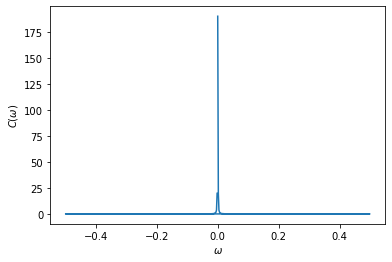

In [13]:

plt.plot(freq, c_omega.real)
plt.xlabel('$\omega$')
plt.ylabel('$C(\omega)$')
plt.show()

Calculate autocorrelation from analytical solution

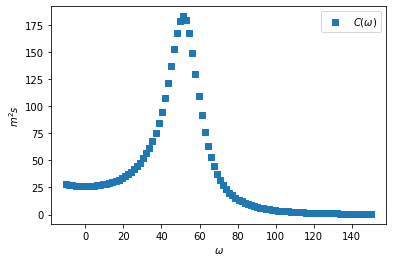

In [14]:
omega_list = np.linspace(-10, 150, 100)
paper_soln = analytical_soln_acf_generic(omega_list, pars)
plt.scatter(omega_list, np.array(paper_soln)/(1e-7), marker = 's', label='$C(\omega)$')
plt.xlabel('$\omega$')
plt.ylabel('$m^2 s$')
plt.legend()
plt.show()

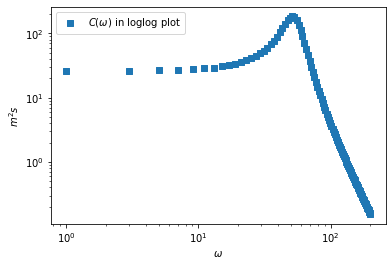

In [15]:
plt.xscale('log')
plt.yscale('log')
omega_new_list = np.linspace(1, 200, 100)
paper_soln_logspace = analytical_soln_acf_generic(omega_new_list, pars)
plt.scatter(omega_new_list, np.array(paper_soln_logspace)/(1e-7), marker = 's', label='$C(\omega)$ in loglog plot')
plt.xlabel('$\omega$')
plt.ylabel('$m^2 s$')
plt.legend()
plt.show()

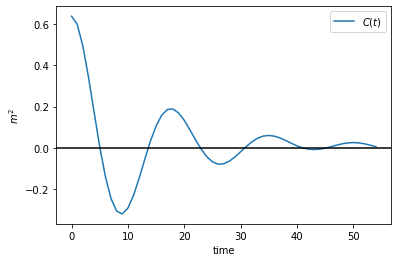

In [16]:
omega_new_list = np.linspace(1, 900, 100)
paper_soln_logspace = analytical_soln_acf_generic(omega_new_list, pars)
inverse_fourier = np.fft.ifft(paper_soln_logspace)
plt.plot(inverse_fourier.real[:55]/(1e-6), label='$C(t)$')
plt.axhline(0*10**-7, color='black')
plt.legend()
plt.xlabel('time')
plt.ylabel('$m^2$')

plt.show()